In [4]:
import glob
import math
import os
import random
import re
import sys
import io

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
from plotter import Vis
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
from tqdm import tqdm


In [7]:
data_path = "../../../Data/training_data_sensor/data_collection/"
new_data_path = "../../../Data/training_data_sensor/training_data_test/"


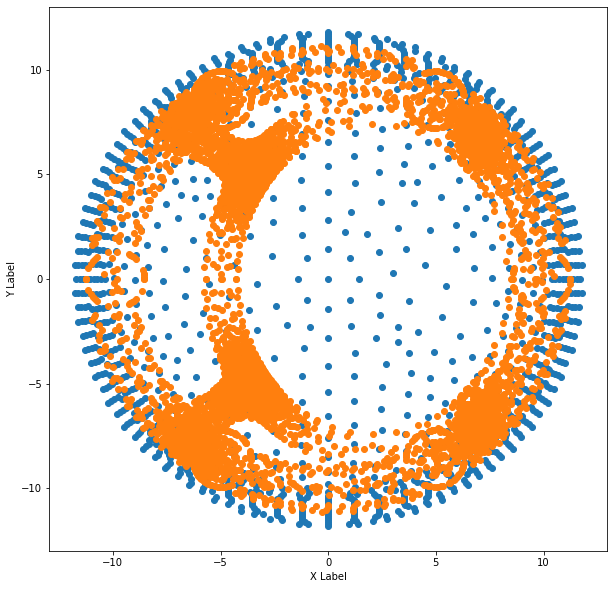

In [20]:
indentation_info = np.load(data_path + "indentation_info.npy")
beam_node = np.load(data_path + "beam_nodes.npy")
outer_surface = np.load(data_path + "nodes_sensor_surface.npy")

#beam_node = np.load(new_data_path + "beam_nodes.npy")
#outer_surface = np.load(new_data_path + "nodes_sensor_surface.npy")

node_num = len(outer_surface)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.scatter(indentation_info[:, 1], indentation_info[:, 2])
ax.scatter(beam_node[:, 1], beam_node[:, 2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

np.save(new_data_path + "indentation_info.npy", indentation_info)
np.save(new_data_path + "beam_nodes.npy", beam_node)
np.save(new_data_path + "nodes_sensor_surface.npy", outer_surface)


##### Extract force measurements from the raw_force data

In [6]:
# Extract ground truth
ground_truth_force = np.zeros((1, 12))
count = 0
#! Change range to the correct amount of folder numbers!

folders = [file for file in os.listdir(
    data_path) if os.path.isdir(os.path.join(data_path, file))]

for folder in tqdm(folders):
    folder_num_string = ''.join(filter(str.isdigit, folder))
    if folder_num_string != "":
        folder_num = int(folder_num_string)

        file_list = glob.glob(os.path.join(
            data_path, folder) + "/raw_force*.npy")
        for file in file_list:

            force_sample = np.load(file)[:11]
            force_sample = np.insert(force_sample, 0, folder_num)

            ground_truth_force = np.vstack((ground_truth_force, force_sample))
            count += 1


global_idx = np.arange(len(ground_truth_force)-1)
ground_truth_force = np.insert(ground_truth_force[1:], 0, global_idx, axis=1)


# Ground Truth force: 0: Global index; 1: Folder Number; 2: Node Number; 3: Image Number, 4,5,6: x,y,z; 7,8,9; fx, fy, fz; 10,11,12: mx,my,mz
np.save(new_data_path + "groundtruth.npy", ground_truth_force)


['folder26', 'folder29', 'folder25', 'folder17', 'folder35', 'folder3', 'folder22', 'folder8', 'folder19', 'folder28', 'folder2', 'folder4', 'folder34', 'folder20', 'folder1', 'NoContact', 'folder30', 'folder23', 'folder15', 'folder27', 'folder6', 'folder5', 'folder31', 'folder11', 'folder33', 'folder10', 'folder0', 'folder7', 'folder18', 'folder13', 'folder16', 'folder9', 'folder12', 'folder14', 'folder21', 'folder32', 'folder24']


100%|██████████| 37/37 [01:49<00:00,  2.97s/it]


In [12]:
# Separate force samples and calculate dataset splits
ground_truth_force = np.load(new_data_path + "groundtruth.npy")

dataset_len = len(ground_truth_force)

sampled_position = np.zeros((dataset_len, 4))
position_index = []

for i in range(dataset_len):
    sampled_position[i] = [
        ground_truth_force[i, 2], *ground_truth_force[i, 4:7]]
    position_index.append(ground_truth_force[i, 2])

all_index = np.unique(position_index)

num_pos = len(all_index)

index = [int(i) for i in np.linspace(0, num_pos-1, num_pos)]
train_index, valid_test = train_test_split(
    index, test_size=0.4, random_state=44)
valid_index, test_index = train_test_split(
    valid_test, test_size=0.5, random_state=45)

train_index_ = []
valid_index_ = []
test_index_ = []

for i in train_index:
    train_index_ += (np.where(position_index == all_index[i])[0].tolist())

for i in valid_index:
    valid_index_ += (np.where(position_index == all_index[i])[0].tolist())

for i in test_index:
    test_index_ += (np.where(position_index == all_index[i])[0].tolist())

np.save(new_data_path + "01_train_index.npy", train_index_)
np.save(new_data_path + "01_valid_index.npy", valid_index_)
np.save(new_data_path + "01_test_index.npy", test_index_)


85041


In [9]:
def preprocess(image):
    return cv2.resize(image, (410, 308), interpolation=cv2.INTER_LINEAR)

In [13]:

y_max = np.max(outer_surface[:, 3])

# Standard notation: force min: 0: global index, 1: node_num, 2: image_num, 3,4,5: x,y,z (testbed); 6,7,8: fx,fy,fz; 9,10,11, mx,my,mz, 12,13,14: x,y,z(nodes), 15,16,17: fx, fy,fz
def force_transfer(force_sample):
    j = force_sample[2]
    for i in range(len(indentation_info)):
        if indentation_info[i, 0] == j:
            force_sample = np.append(force_sample, indentation_info[i, 1:4])

    alpha = np.arctan2(force_sample[14], force_sample[13])
    if force_sample[15] < 20.32:
        sita = 4.0/180.0*np.pi
    else:
        sita = np.arcsin((force_sample[15]-20.32)/(y_max-20.32))

    # sita rotation around x then alpha rotation around z
    fx = force_sample[7]*np.sin(alpha) + (-force_sample[8] *
                                          np.sin(sita)+force_sample[9]*np.cos(sita))*np.cos(alpha)
    fy = - force_sample[7]*np.cos(alpha) + (-force_sample[8]
                                            * np.sin(sita)+force_sample[9]*np.cos(sita))*np.sin(alpha)
    fz = force_sample[8]*np.cos(sita) + force_sample[9]*np.sin(sita)
    force_sample = np.append(force_sample, [fx, fy, fz])

    # Get rid of folder number and swap node number to get back to standard notation
    force_sample = np.delete(force_sample, 1)

    return force_sample


os.makedirs(new_data_path + "PostData/", exist_ok=True)
whole_force = []

for i in tqdm(range(dataset_len)):
    force = ground_truth_force[i]

    try:
        image = cv2.imread(
            data_path + "folder"+str(int(force[1]))+"/RawImage"+str(int(force[3]))+".png")
        image_1 = preprocess(image)
    except:
        print(data_path + "folder" +
              str(int(force[1]))+"/RawImage"+str(int(force[3]))+".png")
        continue

    force = force_transfer(force)

    cv2.imwrite(new_data_path + "PostData/Resized"+str(i)+".png", image_1)
    np.save(new_data_path + "PostData/Reformulated_force"+str(i)+".npy", force)

    whole_force.append(force)

# Save maximum and minimum of all force values across dataset
max_ = np.max(whole_force, axis=0)
min_ = np.min(whole_force, axis=0)

np.save(new_data_path + "groundtruth_max_min.npy", {'max': max_, 'min': min_})


100%|██████████| 85041/85041 [30:41<00:00, 46.17it/s]


# Other Input Images

In [14]:
# No Contact image
image = cv2.imread(data_path+'NoContact_avg.png')
processed_image = preprocess(image)
cv2.imwrite(new_data_path + "PostData/Resized_NoContact.png", processed_image)


# Position reference
position = cv2.imread(data_path + "Position_reference.jpg")
image_pos = preprocess(position)
cv2.imwrite(new_data_path + "PostData/Resized_Position_reference.png", image_pos)


True

## Forcemap Generation

In [16]:
# Col_ind is a vector of length num_nodes. It assigns every node to the corresponding pixel of the flattened output map

def plot_forcemap(indentation_info, col_ind, map_dim):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), facecolor='white')

    norm = mpl.colors.Normalize(
        vmin=min(indentation_info[:, 3]), vmax=max(indentation_info[:, 3]))
    viridis = mpl.cm.get_cmap('viridis')

    for ind in indentation_info:
        ax1.scatter(ind[1], ind[2], color=viridis(norm(ind[3])))

    ax1.set_ylim(-20, 20)
    ax1.set_xlim(-20, 20)
    ax1.set_xticks([])
    ax1.set_yticks([])
    map = np.ones((map_dim*map_dim, 3))*255

    for i in range(0, len(indentation_info)):

        map[col_ind[i]] = viridis(norm(indentation_info[i, 3]))[:-1]

    map = map.reshape(map_dim, map_dim, 3)
    ax2.imshow(map)
    ax2.set_xticks([])
    ax2.set_yticks([])


# Use Laplacian1 distribtuion to model the force distribution around the contact

num_nodes = len(indentation_info)
distance2 = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    distance2[i, :] = np.exp(-0.5*np.linalg.norm(indentation_info[:,
                             1:4]-indentation_info[i, 1:4], axis=1)*1.15)
    for j in range(num_nodes):
        if np.linalg.norm(indentation_info[j, 1:4]-indentation_info[i, 1:4]) > 16.0:
            distance2[i, j] = 0

np.save(new_data_path + "Distance2.npy", distance2)
print("Saved {} nodes".format(num_nodes))


Saved 1350 nodes


### Hungarian matching

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 85041/85041 [01:01<00:00, 1375.44it/s]


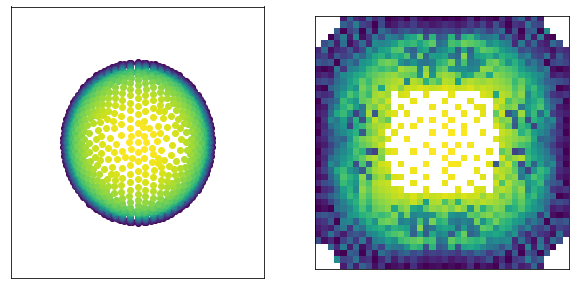

In [17]:
# Use Hungarian matching to match the 1350 nodes of the 3D finger model to the 1600 pixels of the 40x40 output force map
# We only consider x and y coordinates for the matching

map_dim = 40
map_dir = new_data_path + "MapData/"
os.makedirs(map_dir, exist_ok=True)

max_node = max(indentation_info[:, 1])
min_node = min(indentation_info[:, 1])

inc = (max_node - min_node) / float(map_dim-1)

node_pos = np.column_stack((indentation_info[:, 1], indentation_info[:, 2]))

pixel_pos = [[j, i] for i in np.arange(
    min_node, max_node + inc, inc) for j in np.arange(min_node, max_node+inc, inc)]
dist_matrix = distance_matrix(node_pos, pixel_pos)
row_ind, col_ind = linear_sum_assignment(dist_matrix)

np.save(map_dir + "column_idx_mapping.npy", col_ind)
plot_forcemap(indentation_info, col_ind, map_dim)


for distance_index in [2]:
    distance = np.load(new_data_path + "Distance"+str(distance_index)+".npy")
    for i in tqdm(range(0, dataset_len)):
        force = np.load(
            new_data_path + "PostData/Reformulated_force"+str(i)+".npy")
        for j in range(num_nodes):
            if force[1] == indentation_info[j, 0]:
                break

        map = np.zeros((3, map_dim*map_dim))
        a1 = force[15]/np.sum(distance[j])
        map[0, col_ind] = a1*distance[j]
        a2 = force[16]/np.sum(distance[j])
        map[1, col_ind] = a2*distance[j]
        a3 = force[17]/np.sum(distance[j])
        map[2, col_ind] = a3*distance[j]

        map = map.reshape(3, map_dim, map_dim)

        map = torch.from_numpy(map).float()

        torch.save(map, map_dir + "Map" +
                   str(distance_index)+"_"+str(i)+".txt")


### Weighted Hungarian matching

0.0 6.653421186143309e-16
1349


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 85041/85041 [00:50<00:00, 1669.55it/s]


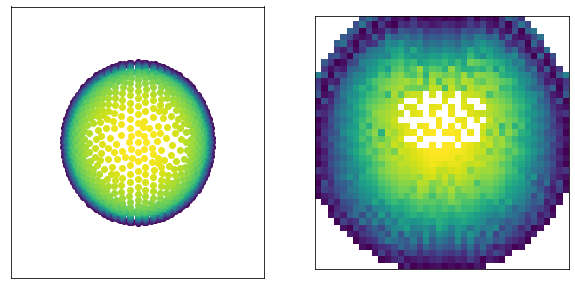

In [18]:
# Improve Hungarian matching with additional coefficient for euclidian distance metric, dependent on z

map_dim = 40
map_dir = new_data_path + "MapData_weighted/"
os.makedirs(map_dir, exist_ok=True)

max_node_x = max(indentation_info[:, 1])
min_node_x = min(indentation_info[:, 1])
max_node_y = max(indentation_info[:, 2])
min_node_y = min(indentation_info[:, 2])

z_max = max(indentation_info[:, 3])
max_i = np.argmax(indentation_info[:, 3])
print(indentation_info[max_i, 1], indentation_info[max_i, 2])
print(max_i)
inc_x = (max_node_x - min_node_x) / float(map_dim-1)
inc_y = (max_node_y - min_node_y) / float(map_dim-1)


def dfun(u, v):
    u[0] = u[0]*(z_max-u[2]/2000)/z_max
    u[1] = u[1]*(z_max-u[2]/2000)/z_max
    return np.sqrt(((u[:2]-v[:2])**2).sum())


node_pos = np.column_stack(
    (indentation_info[:, 1], indentation_info[:, 2], indentation_info[:, 3]))
pixel_pos = [[j, i, 0] for i in np.arange(
    min_node_y, max_node_y + inc_y, inc_y) for j in np.arange(min_node_x, max_node_x + inc_x, inc_x)]


dist_matrix = pairwise_distances(node_pos, pixel_pos, dfun)
row_ind, col_ind = linear_sum_assignment(dist_matrix)
np.save(map_dir + "column_idx_mapping.npy", col_ind)

map = np.ones((map_dim*map_dim))*255
plot_forcemap(indentation_info, col_ind, map_dim)

for distance_index in [2]:
    distance = np.load(new_data_path + "Distance"+str(distance_index)+".npy")
    for i in tqdm(range(0, dataset_len)):
        force = np.load(
            new_data_path + "PostData/Reformulated_force"+str(i)+".npy")
        for j in range(num_nodes):
            if force[1] == indentation_info[j, 0]:
                break

        map = np.zeros((3, map_dim*map_dim))
        a1 = force[15]/np.sum(distance[j])
        map[0, col_ind] = a1*distance[j]
        a2 = force[16]/np.sum(distance[j])
        map[1, col_ind] = a2*distance[j]
        a3 = force[17]/np.sum(distance[j])
        map[2, col_ind] = a3*distance[j]

        map = map.reshape(3, map_dim, map_dim)

        map = torch.from_numpy(map).float()

        torch.save(map, map_dir + "Map" +
                   str(distance_index)+"_"+str(i)+".txt")


## Flat Vector Labels

In [19]:
from torch.nn.functional import normalize

map_dir = new_data_path + "MapData_flat/"
os.makedirs(map_dir, exist_ok=True)

for distance_index in [2]:
    distance = np.load(new_data_path + "Distance"+str(distance_index)+".npy")
    for i in tqdm(range(20100, dataset_len)):
        force = np.load(
            new_data_path + "PostData/Reformulated_force"+str(i)+".npy")
        for j in range(num_nodes):
            if force[1] == indentation_info[j, 0]:
                break

        map = np.zeros((3, num_nodes))
        a1 = force[15]/np.sum(distance[j])
        map[0, :] = a1*distance[j]

        a2 = force[16]/np.sum(distance[j])
        map[1, :] = a2*distance[j]
        a3 = force[17]/np.sum(distance[j])
        map[2, :] = a3*distance[j]
        map = map.reshape(3*num_nodes)
        map = torch.from_numpy(map).float()

        torch.save(map, map_dir + "Map" +
                   str(distance_index)+"_"+str(i)+".txt")


100%|██████████| 64941/64941 [00:38<00:00, 1669.15it/s]


# Visualization

tensor(0.0143)


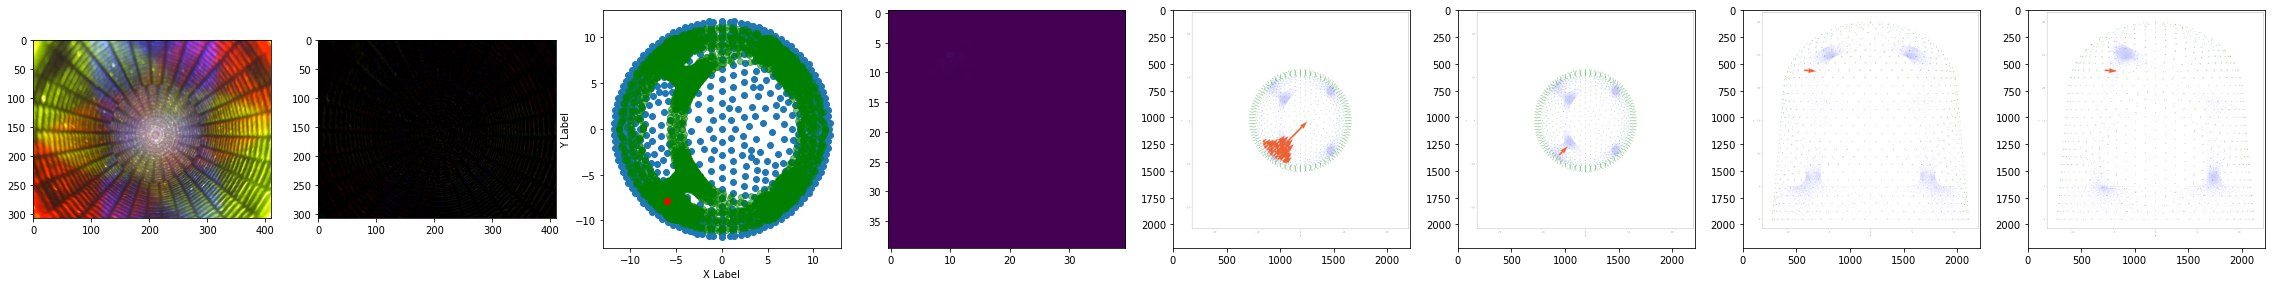

tensor(0.9739)


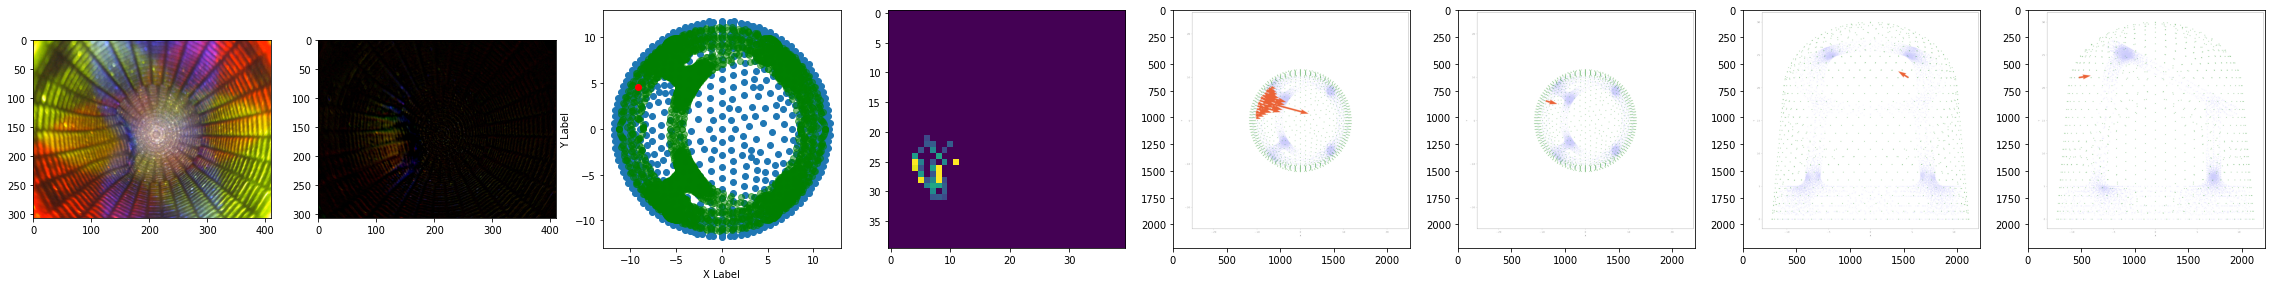

tensor(0.0575)


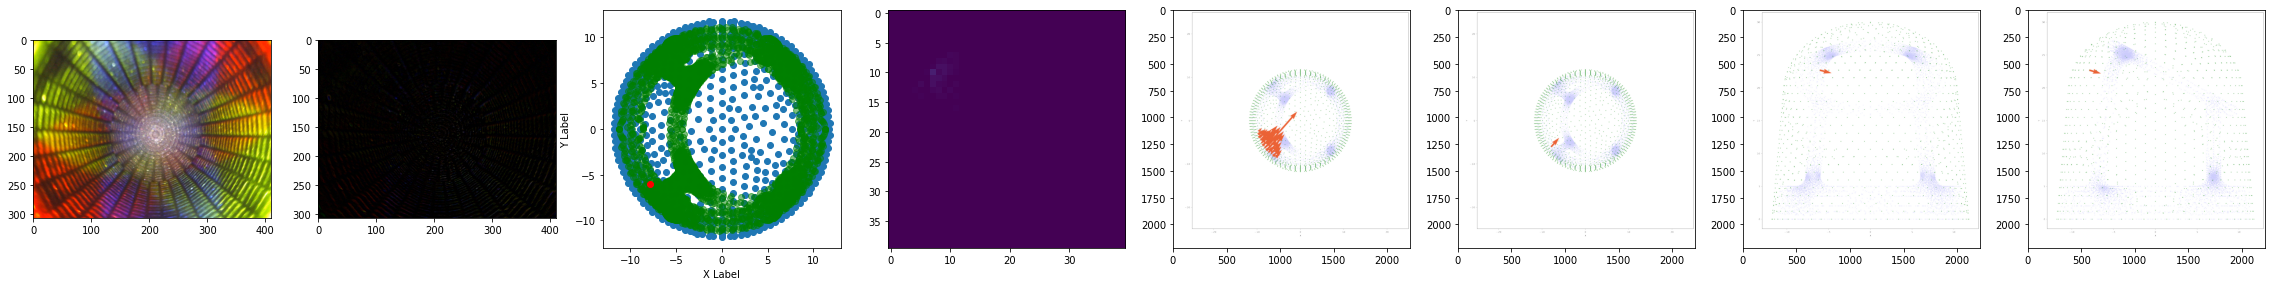

tensor(0.8024)


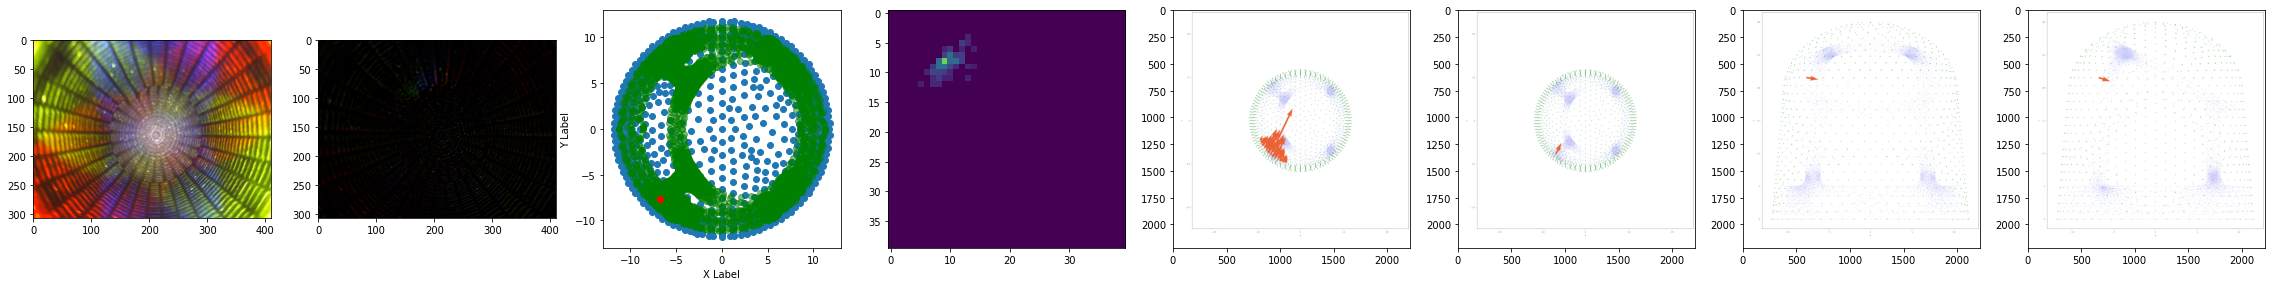

tensor(0.0425)


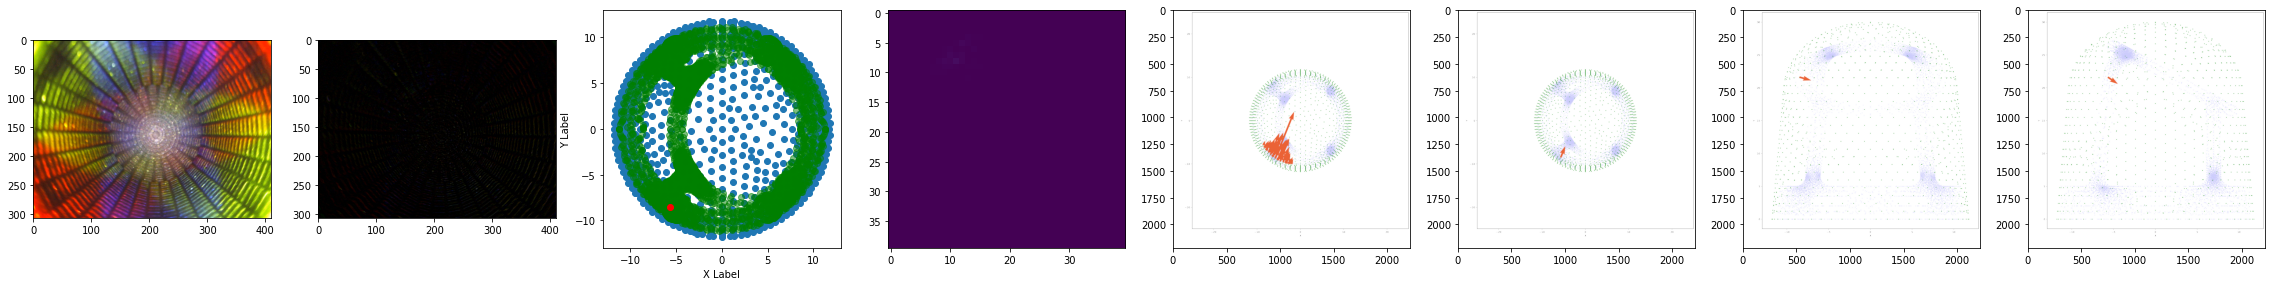

tensor(0.7998)


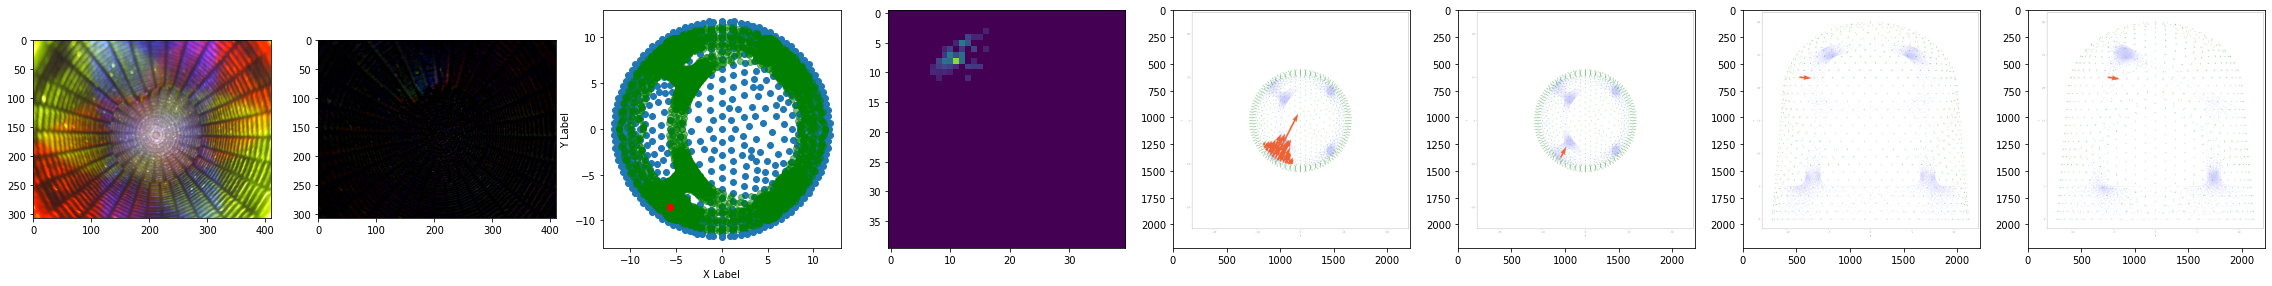

tensor(0.5123)


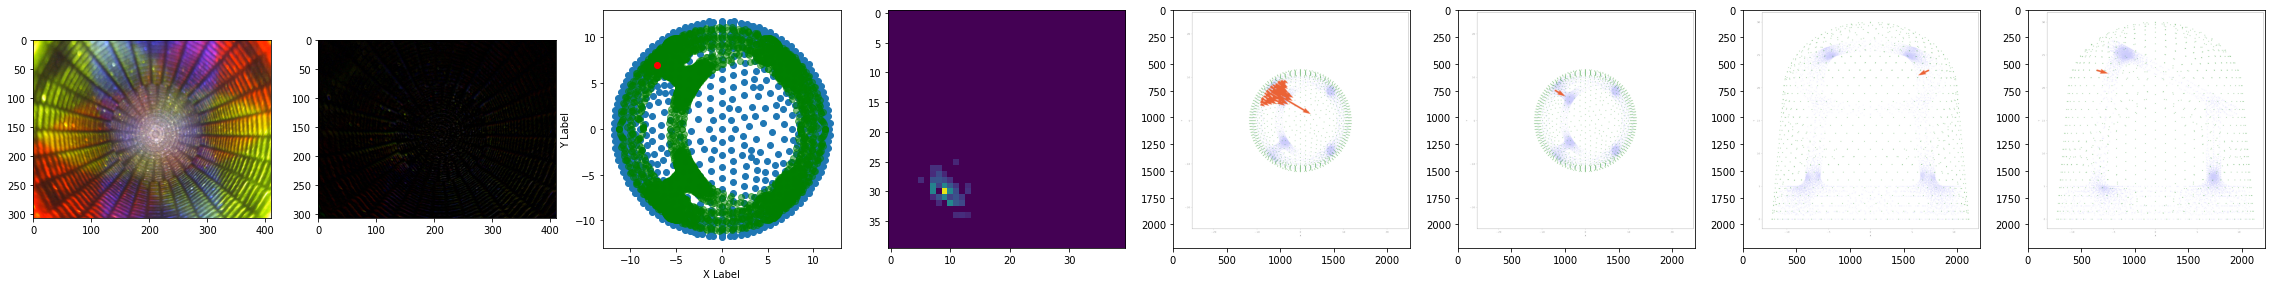

tensor(0.2005)


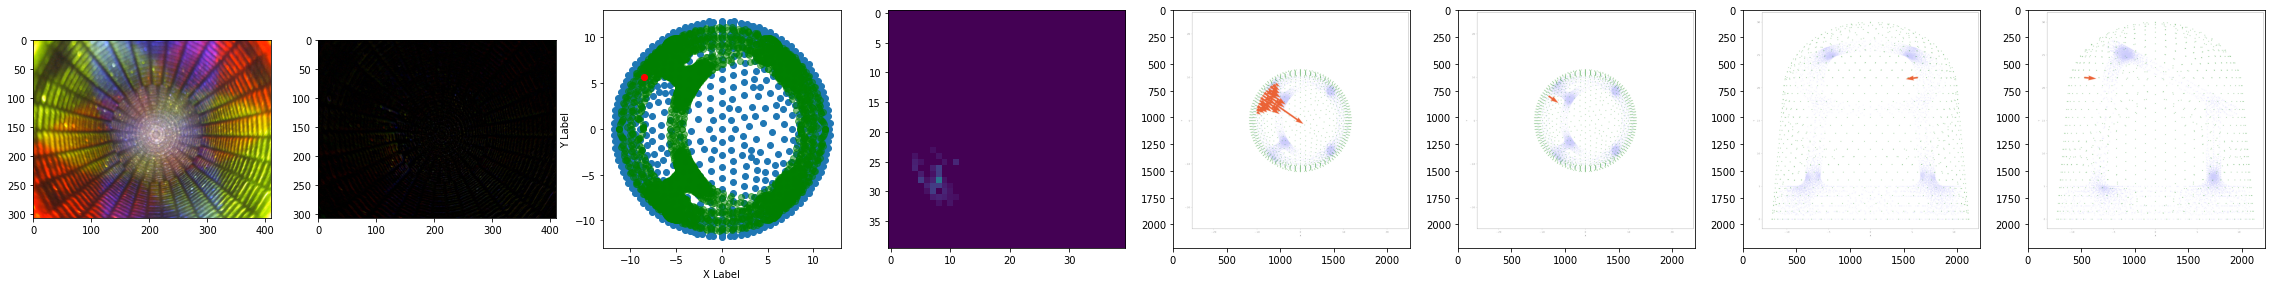

tensor(0.1062)


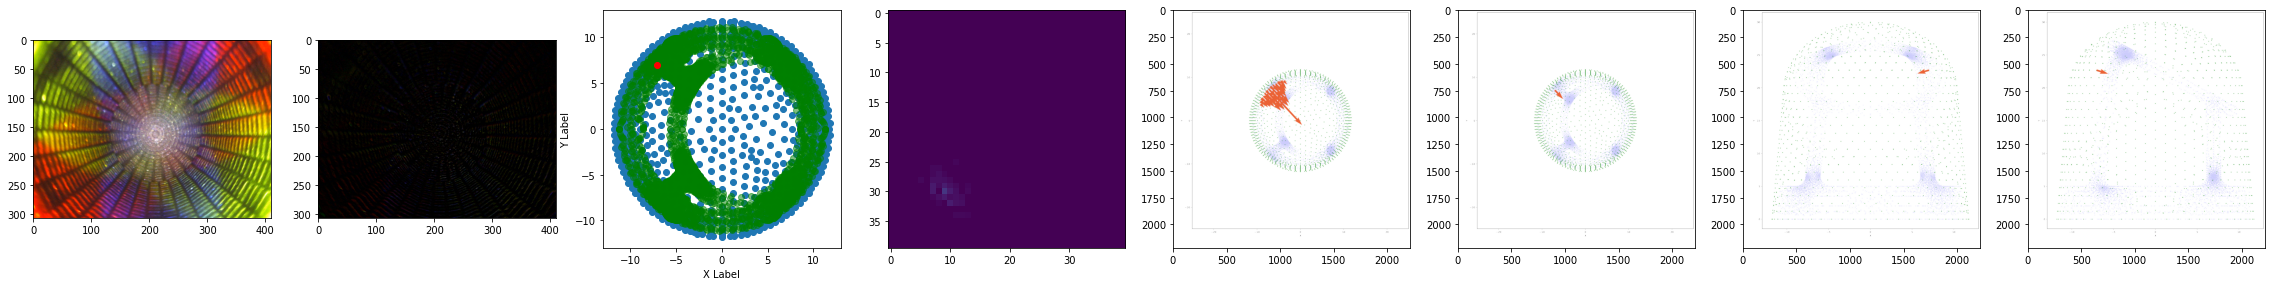

tensor(0.5793)


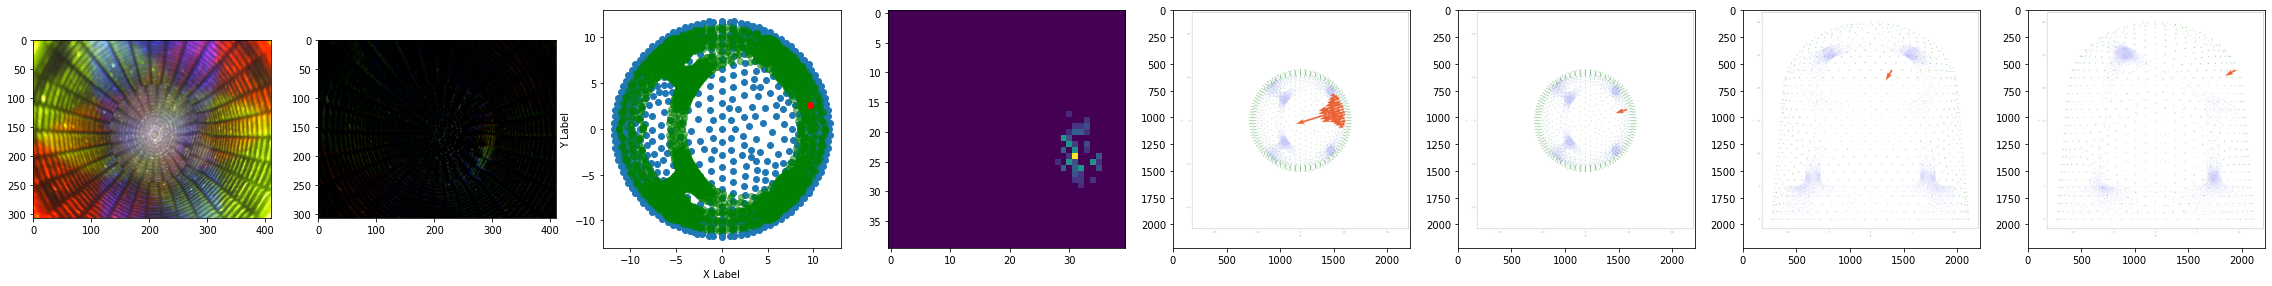

In [26]:
beam_node = np.load(new_data_path + "beam_nodes.npy")
indentation_info = np.load(new_data_path + "indentation_info.npy")
avg_image = cv2.imread(new_data_path + "NoContact_avg.png")
map_dir = new_data_path + "MapData/"

vis = Vis(beam_node, indentation_info, col_ind, map_dim)

for i in range(20000, 20010):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7,
          ax8) = plt.subplots(1, 8, figsize=(40, 10))
    image = cv2.imread(new_data_path + "PostData/Resized"+str(i)+".png")
    ax1.imshow(image)
    ax2.imshow(cv2.subtract(image, avg_image))
    ax3.scatter(indentation_info[:, 1], indentation_info[:, 2])
    force = np.load(
        new_data_path + "PostData/Reformulated_force"+str(i)+".npy")
    ax3.scatter(beam_node[:, 1],
                beam_node[:, 2], color='g', alpha=0.5)

    ax3.scatter(force[12], force[13], color="r")

    ax3.set_xlabel('X Label')
    ax3.set_ylabel('Y Label')
    ax3.set_aspect('equal', adjustable='box')

    map = torch.load(map_dir + "Map2"+"_"+str(i)+".txt")
    print(torch.norm(torch.tensor(
        [torch.sum(map[0]), torch.sum(map[1]), torch.sum(map[2])])))
    ax4.imshow(abs(map[0]), cmap='viridis', vmin=0.0, vmax=0.05)

    ax5.imshow(vis.force_map_vis(map))

    ax6.imshow(vis.force_vec_vis(force[12:18]))
    ax7.imshow(vis.force_vec_visyz((force[12:18])))
    ax8.imshow(vis.force_vec_visxz((force[12:18])))

    display(fig)
    plt.close(fig)